In [ ]:
import pandas as pd

In [ ]:
#!pip3 install -U ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

In [ ]:
# fetch dataset
dia_130 = fetch_ucirepo(id=296)
# metadata
print("A metadata Description")
print(dia_130.metadata)

print(dia_130.shape)

#variable information
print(dia_130.variables)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


A metadata Description
{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control.

In [ ]:
# data (as pandas dataframes)
X_130 = dia_130.data.features
y_130 = dia_130.data.targets

print("DataFrame")
pandas_df = pd.DataFrame(X_130, columns=dia_130.feature_names)
pandas_df.drop(['weight','payer_code','medical_specialty'], axis = 1, inplace = True)
pandas_df = pandas_df.dropna(subset=['race','diag_1', 'diag_2', 'diag_3'])
y_130_aligned = y_130.loc[pandas_df.index]
print(pandas_df.shape)
print("Features and number of NaN values per feature/column")
v1_130 = pandas_df.isnull().sum()
print(v1_130)
print(y_130_aligned)
print(y_130_aligned.shape)


DataFrame
(98053, 44)
Features and number of NaN values per feature/column
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                 

In [ ]:
print(pandas_df.head())
print(pandas_df.dtypes)

In [ ]:
pandas_df_tar = pd.DataFrame(y_130_aligned, columns=dia_130.target_names)
print(pandas_df_tar.shape)
print(pandas_df_tar.isnull().sum())

(98053, 1)
readmitted    0
dtype: int64


map diagnosis codes to categories

In [ ]:
# Step 1: Read the CSV and create the mapping dictionary
icd_9_codes_url = 'https://raw.githubusercontent.com/brotaur/MLdiabetes/main/Converstion%20table2.csv'
icd_9_codes_df = pd.read_csv(icd_9_codes_url, encoding='ISO-8859-1')
icd_9_code_mapping = icd_9_codes_df.set_index('Diag Code')['Diag Category'].to_dict()

# Step 2: Apply the mapping to your DataFrame
icd_9_columns = ['diag_1', 'diag_2', 'diag_3']

for column in icd_9_columns:
    pandas_df[column] = pandas_df[column].map(icd_9_code_mapping)

# At this point, diag_1, diag_2, and diag_3 in your DataFrame have been replaced
# with their corresponding diagnostic categories from the CSV
print(pandas_df)


                   race  gender      age  admission_type_id  \
1             Caucasian  Female  [10-20)                  1   
2       AfricanAmerican  Female  [20-30)                  1   
3             Caucasian    Male  [30-40)                  1   
4             Caucasian    Male  [40-50)                  1   
5             Caucasian    Male  [50-60)                  2   
...                 ...     ...      ...                ...   
101761  AfricanAmerican    Male  [70-80)                  1   
101762  AfricanAmerican  Female  [80-90)                  1   
101763        Caucasian    Male  [70-80)                  1   
101764        Caucasian  Female  [80-90)                  2   
101765        Caucasian    Male  [70-80)                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
1                              1                    7                 3   
2                              1                    7                 2   
3                 

In [ ]:
# Step 2: Inspect unique values after mapping
print("Unique categories in 'diag_1' after mapping:", pandas_df['diag_1'].unique()[:10])

# Step 3: Sample rows check
print("Sample rows from the DataFrame:")
print(pandas_df[['diag_1', 'diag_2', 'diag_3']].sample(5))

# Step 4: Check for unmapped codes (assuming all codes should be mapped)
unmapped_check = pandas_df[['diag_1', 'diag_2', 'diag_3']].isnull().any()
print("Columns with unmapped codes:", unmapped_check)


Unique categories in 'diag_1' after mapping: ['Other metabolic and immunity disorders'
 'Complications Mainly Related To Pregnancy'
 'Intestinal infectious diseases'
 'Malignant neoplasm of other and unspecified sites'
 'Ischemic Heart Disease' 'Other Forms Of Heart Disease'
 'Chronic Rheumatic Heart Disease' 'Cerebrovascular Disease'
 'Diabetes mellitus'
 'Malignant neoplasm of digestive organs and peritoneum']
Sample rows from the DataFrame:
                                                  diag_1  \
72258                    Diseases Of Male Genital Organs   
86098                  Diseases Of Pulmonary Circulation   
67755  Neurotic disorders, personality disorders, and...   
29731                             Ischemic Heart Disease   
93746                             Fracture Of Upper Limb   

                                     diag_2  \
72258       Disorders Of The Eye And Adnexa   
86098          Other Forms Of Heart Disease   
67755  Other Diseases Of Respiratory System   
297

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize one LabelEncoder per column to keep track of the mappings
label_encoder_diag_1 = LabelEncoder()
label_encoder_diag_2 = LabelEncoder()
label_encoder_diag_3 = LabelEncoder()

# Apply Label Encoding for 'diag_1', 'diag_2', 'diag_3'
pandas_df['diag_1_encoded'] = label_encoder_diag_1.fit_transform(pandas_df['diag_1'])
pandas_df['diag_2_encoded'] = label_encoder_diag_2.fit_transform(pandas_df['diag_2'])
pandas_df['diag_3_encoded'] = label_encoder_diag_3.fit_transform(pandas_df['diag_3'])

# Display the first few rows to verify the encoded columns
print(pandas_df[['diag_1', 'diag_1_encoded', 'diag_2', 'diag_2_encoded', 'diag_3', 'diag_3_encoded']].head())
print(pandas_df)


                                              diag_1  diag_1_encoded  \
1             Other metabolic and immunity disorders              98   
2          Complications Mainly Related To Pregnancy              15   
3                     Intestinal infectious diseases              57   
4  Malignant neoplasm of other and unspecified sites              66   
5                             Ischemic Heart Disease              59   

                                              diag_2  diag_2_encoded  \
1                                  Diabetes mellitus              28   
2                                  Diabetes mellitus              28   
3                                  Diabetes mellitus              28   
4  Malignant neoplasm of digestive organs and per...              74   
5                             Ischemic Heart Disease              69   

                                              diag_3  diag_3_encoded  
1                        Disorders of adrenal glands           

In [ ]:
label_encoder_race = LabelEncoder()
label_encoder_gender = LabelEncoder()
label_encoder_change = LabelEncoder()
label_encoder_diabetesMed = LabelEncoder()

# Apply Label Encoding for race, gender, change, and diabetesMed
pandas_df['race'] = label_encoder_diag_1.fit_transform(pandas_df['race'])
pandas_df['gender'] = label_encoder_diag_2.fit_transform(pandas_df['gender'])
pandas_df['change'] = label_encoder_diag_3.fit_transform(pandas_df['change'])
pandas_df['diabetesMed'] = label_encoder_diag_1.fit_transform(pandas_df['diabetesMed'])


print(pandas_df[['race', 'gender', 'change','diabetesMed']].head())

   race  gender  change  diabetesMed
1     2       0       0            1
2     0       0       1            1
3     2       1       0            1
4     2       1       0            1
5     2       1       1            1


In [ ]:
pandas_df.dtypes

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Mapping
age_mapping = {'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7,'[80-90)':8, '[90-100)':9}
max_glu_serum_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
A1Cresult_mapping = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
metformin_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
repaglinide_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
nateglinide_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
chlorpropamide_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
glimepiride_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
acetohexamide_mapping = {'No':0, 'Steady': 1}
glipizide_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
glyburide_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
tolbutamide_mapping = {'No':0, 'Steady': 1}
pioglitazone_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
rosiglitazone_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
acarbose_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
miglitol_mapping = {'No':0, 'Steady': 1, 'Up':2, 'Down':3}
troglitazone_mapping = {'No':0, 'Steady': 1}
tolazamide_mapping = {'No':0, 'Steady': 1, 'Up':2}
examide_mapping = {'No':0}
citoglipton_mapping = {"No": 0}
insulin_mapping = {"No": 0, "Steady": 1, "Up": 2, "Down": 3}
glyburide_metformin_mapping = {"No": 0, "Steady": 1, "Up": 2, "Down": 3}
glipizide_metformin_mapping = {"No": 0, "Steady": 1}
glimepiride_pioglitazone_mapping = {"No": 0, "Steady": 1}
metformin_rosiglitazone_mapping = {'No':0}
metformin_pioglitazone_mapping = {'No':0, 'Steady': 1}

# Applying mapping
pandas_df['age'] = pandas_df['age'].map(age_mapping)
pandas_df['max_glu_serum'] = pandas_df['max_glu_serum'].map(max_glu_serum_mapping)
pandas_df['A1Cresult'] = pandas_df['A1Cresult'].map(A1Cresult_mapping)
pandas_df['metformin'] = pandas_df['metformin'].map(metformin_mapping)
pandas_df['repaglinide'] = pandas_df['repaglinide'].map(repaglinide_mapping)
pandas_df['nateglinide'] = pandas_df['nateglinide'].map(nateglinide_mapping)
pandas_df['chlorpropamide'] = pandas_df['chlorpropamide'].map(chlorpropamide_mapping)
pandas_df['glimepiride'] = pandas_df['glimepiride'].map(glimepiride_mapping)
pandas_df['acetohexamide'] = pandas_df['acetohexamide'].map(acetohexamide_mapping)
pandas_df['glipizide'] = pandas_df['glipizide'].map(glipizide_mapping)
pandas_df['glyburide'] = pandas_df['glyburide'].map(glyburide_mapping)
pandas_df['tolbutamide'] = pandas_df['tolbutamide'].map(tolbutamide_mapping)
pandas_df['pioglitazone'] = pandas_df['pioglitazone'].map(pioglitazone_mapping)
pandas_df['rosiglitazone'] = pandas_df['rosiglitazone'].map(rosiglitazone_mapping)
pandas_df['acarbose'] = pandas_df['acarbose'].map(acarbose_mapping)
pandas_df['miglitol'] = pandas_df['miglitol'].map(miglitol_mapping)
pandas_df['troglitazone'] = pandas_df['troglitazone'].map(troglitazone_mapping)
pandas_df['tolazamide'] = pandas_df['tolazamide'].map(tolazamide_mapping)
pandas_df['examide'] = pandas_df['examide'].map(examide_mapping)
pandas_df['citoglipton'] = pandas_df['citoglipton'].map(citoglipton_mapping)
pandas_df['insulin'] = pandas_df['insulin'].map(insulin_mapping)
pandas_df['glyburide-metformin'] = pandas_df['glyburide-metformin'].map(glyburide_metformin_mapping)
pandas_df['glipizide-metformin'] = pandas_df['glipizide-metformin'].map(glipizide_metformin_mapping)
pandas_df['glimepiride-pioglitazone'] = pandas_df['glimepiride-pioglitazone'].map(glimepiride_pioglitazone_mapping)
pandas_df['metformin-rosiglitazone'] = pandas_df['metformin-rosiglitazone'].map(metformin_rosiglitazone_mapping)
pandas_df['metformin-pioglitazone'] = pandas_df['metformin-pioglitazone'].map(metformin_pioglitazone_mapping)

In [ ]:
pandas_df.dtypes

In [ ]:
pandas_df_numeric = pandas_df.drop(columns=['diag_1', 'diag_2', 'diag_3'])
pandas_df_numeric.dtypes

race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
pioglitazone                int64
rosiglitazone               int64
acarbose                    int64
miglitol                    int64
troglitazone  

In [ ]:
 pandas_df_numeric.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [ ]:
pandas_df_numeric.shape

In [ ]:
pandas_df_numeric

In [ ]:
pandas_df_tar

Text(0.5, 0, 'Count')

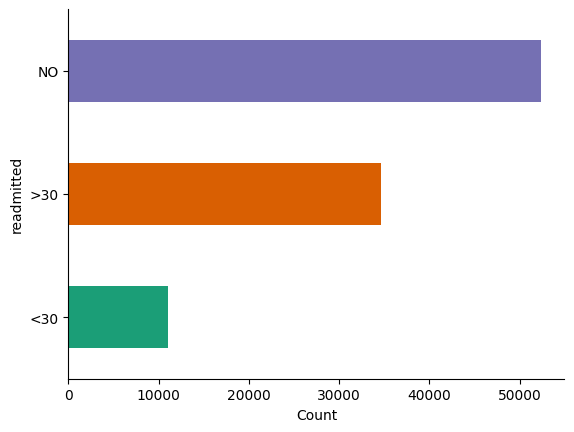

In [ ]:
# @title readmitted

from matplotlib import pyplot as plt
import seaborn as sns
pandas_df_tar.groupby('readmitted').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Count')

In [ ]:
# prompt: Using dataframe pandas_df_tar: replace the categories >30 and NO by 0, and <30 by 1 and save this df as pandas_df_tar_binom

pandas_df_tar_binom = pandas_df_tar.copy()
pandas_df_tar_binom['readmitted'] = pandas_df_tar_binom['readmitted'].replace({'>30': 0, 'NO': 0, '<30': 1})
pandas_df_tar_binom['readmitted'].value_counts()

0    86987
1    11066
Name: readmitted, dtype: int64

Text(0.5, 0, 'Count')

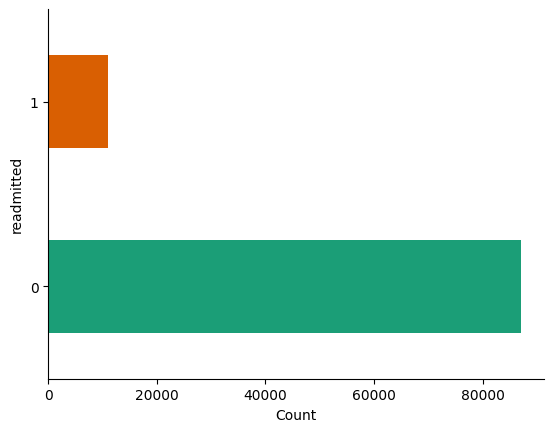

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
pandas_df_tar_binom.groupby('readmitted').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Count')

looking at descriptions of the data

In [ ]:
pandas_df_numeric.describe()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_1_encoded,diag_2_encoded,diag_3_encoded
count,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,...,98053.000000,98053.000000,98053.000000,98053.0,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000,98053.000000
mean,1.659011,0.461189,6.126034,2.025813,3.753368,5.776692,4.421976,43.148073,1.350749,16.119650,...,0.006945,0.000133,0.000010,0.0,0.000010,0.538219,0.768472,62.143065,75.532926,72.977502
std,0.860882,0.498514,1.559075,1.450117,5.309392,4.071640,2.993074,19.712033,1.708506,8.108476,...,0.084871,0.011514,0.003194,0.0,0.003194,0.498540,0.421811,35.572248,38.924197,38.782626
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,11.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,23.000000,28.000000,29.000000
50%,2.000000,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,59.000000,87.000000,69.000000
75%,2.000000,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,92.000000,108.000000,108.000000
max,4.000000,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,...,3.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,120.000000,143.000000,143.000000


Try some correlation analysis

In [ ]:
# prompt: merge pandas_df_numeric and pandas_df_tar_binom, and then generate a vif matrix and identify highly collinear features

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Merge pandas_df_numeric and pandas_df_tar_binom
df_merged = pd.merge(pandas_df_numeric, pandas_df_tar_binom, left_index=True, right_index=True)

# Generate VIF matrix
vif_df = pd.DataFrame()
vif_df["features"] = df_merged.columns
vif_df["vif_value"] = [vif(df_merged.values, i) for i in range(df_merged.shape[1])]

# Identify highly collinear features
threshold = 5
high_vif_features = vif_df[vif_df["vif_value"] > threshold]["features"].tolist()

# Print the highly collinear features
print("Highly collinear features:")
print(high_vif_features)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Highly collinear features:
['age', 'num_lab_procedures', 'num_medications', 'number_diagnoses', 'change', 'diabetesMed']


In [ ]:
# prompt: in df_merged, generate a correlation matrix and identify the pairs of features with high correlation, threshold being 0.4

import matplotlib.pyplot as plt
import pandas as pd

# Calculate the correlation matrix
correlation_matrix = df_merged.corr()

# Select the pairs of features with high correlation
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.4:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print the pairs of features with high correlation
print("Pairs of features with high correlation (threshold 0.4):")
for pair in high_correlation_pairs:
    print(f"{pair[0]}, {pair[1]}")


Pairs of features with high correlation (threshold 0.4):
admission_source_id, max_glu_serum
time_in_hospital, num_medications
insulin, change
insulin, diabetesMed
change, diabetesMed


split data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

X = pandas_df_numeric
#y = pandas_df_tar
y = pandas_df_tar_binom

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% of data for testing

SMOTE application

In [ ]:
#SMOTE application:
#print(X_train.shape)
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set to handle class imbalance
smt = SMOTE(random_state=42, sampling_strategy = 0.8)
#smt = SMOTE(random_state=42)
X_smote, y_smote = smt.fit_resample(X, y)

print("New class distribution after SMOTE:", Counter(y_smote['readmitted']))

#A before and after of the dataset before the application of SMOTE and after
print("Shape of X and y before SMOTE:", X.shape, " and ", y.shape)
print("Shape of X and y after SMOTE:", X_smote.shape, " and ", y_smote.shape)

print(y_smote.head)

New class distribution after SMOTE: Counter({0: 86987, 1: 69589})
Shape of X and y before SMOTE: (98053, 44)  and  (98053, 1)
Shape of X and y after SMOTE: (156576, 44)  and  (156576, 1)
<bound method NDFrame.head of         readmitted
0                0
1                0
2                0
3                0
4                0
...            ...
156571           1
156572           1
156573           1
156574           1
156575           1

[156576 rows x 1 columns]>


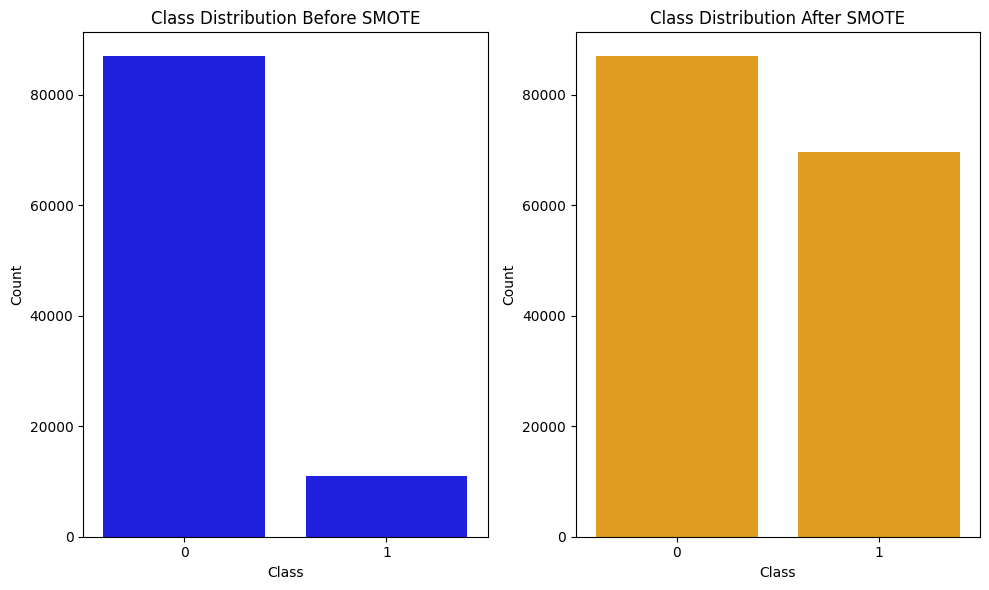

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

original_counts = Counter(y['readmitted'])
new_counts = Counter(y_smote['readmitted'])

# Create a bar plot to visualize the class distribution before and after SMOTE
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), color='blue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')

# Create a bar plot to visualize the class distribution after SMOTE
plt.subplot(1, 2, 2)
sns.barplot(x=list(new_counts.keys()), y=list(new_counts.values()), color='orange')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)  # 20% of data for testing

# include a cross validation step as well

Apply scaling to the training data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform it
#X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train)
y_train = y_train  # using smote y data to fit

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


SMOTE work

Implmentation of SVM Model

Will also try running SVM through sklearn.model_selection.GridSearchCV tomorrow
1. First SVM shows RBF kernel using grid_searchcv
2. Second SVM shows LinearSVM using linear kernel using gridsearchcv
3. Also tried running SMOTE above 2 cells

In [ ]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV


Both the GridSearchCVs are taking too long so we will use normal SVM and linear SVM for now.

In [ ]:
# Initialize an SVM with the RBF kernel
rbf_svc = svm.SVC(kernel='rbf')

# Fit the SVM to the scaled training data
rbf_svc.fit(X_train_scaled, y_train.values.ravel())

# Make predictions using the SVM on the test set
rbf_predictions = rbf_svc.predict(X_test_scaled)

# Calculate the confusion matrix and accuracy score for RBF SVM
rbf_confusion_matrix_results = confusion_matrix(y_test.values.ravel(), rbf_predictions)
rbf_accuracyScore = accuracy_score(y_test.values.ravel(), rbf_predictions)

# Print the results for RBF SVM
print("Confusion matrix for RBF SVM:", rbf_confusion_matrix_results)
print(f"Accuracy Score for RBF SVM: {rbf_accuracyScore}")

# Initialize a LinearSVC
linear_svc = svm.LinearSVC()

# Fit the LinearSVC to the scaled training data
linear_svc.fit(X_train_scaled, y_train.values.ravel())

# Make predictions using the LinearSVC on the test set
linear_predictions = linear_svc.predict(X_test_scaled)

# Calculate the confusion matrix and accuracy score for LinearSVC
linear_confusion_matrix_results = confusion_matrix(y_test.values.ravel(), linear_predictions)
linear_accuracyScore = accuracy_score(y_test.values.ravel(), linear_predictions)

# Print the results for LinearSVC
print("Confusion matrix for LinearSVC:", linear_confusion_matrix_results)
print(f"Accuracy Score for LinearSVC: {linear_accuracyScore}")


Confusion matrix for RBF SVM: [[17308   113]
 [ 3870  3066]]
Accuracy Score for RBF SVM: 0.8364741142176787
Confusion matrix for LinearSVC: [[16865   556]
 [ 4008  2928]]
Accuracy Score for LinearSVC: 0.8126206018803629


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# # Define parameter grid for GridSearchCV with both 'C' and 'gamma' for the RBF kernel
# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

# # Initialize GridSearchCV with svm.SVC using the RBF kernel and the parameter grid
# grid_search_rbf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)

# # Fit GridSearchCV to the scaled training data
# grid_search_rbf.fit(X_train_scaled, y_train.values.ravel())

# # Get the best estimator directly from GridSearchCV
# best_rbf_svc = grid_search_rbf.best_estimator_

# # Make predictions using the best found parameters on the test set
# predictions = best_rbf_svc.predict(X_test_scaled)

# # Calculate the confusion matrix and accuracy score
# confusion_matrix_results = confusion_matrix(y_test.values.ravel(), predictions)
# accuracyScore = accuracy_score(y_test.values.ravel(), predictions)

# # Print the results
# print("Best parameters found by GridSearchCV:", grid_search_rbf.best_params_)
# print(confusion_matrix_results)
# print(f"Accuracy Score: {accuracyScore}")

A figure that shows the performance of the model across the different hyperparameter values. Expectation: We arrive at a set of hyperparams which will result in best performance in terms of accuracy etc.

In [ ]:
# # Define parameter grid for GridSearchCV, without the gamma parameter for LinearSVC
# param_grid = {'C': [0.1, 1, 10, 100]}

# # Initialize GridSearchCV with LinearSVC and the adjusted parameter grid
# grid_search_linear = GridSearchCV(svm.LinearSVC(), param_grid, cv=5)

# # Fit GridSearchCV to the scaled training data
# grid_search_linear.fit(X_train_scaled, y_train.values.ravel())

# # Get the best estimator directly from GridSearchCV
# best_linear_svc = grid_search_linear.best_estimator_

# # Make predictions using the best found parameters on the test set
# predictions = best_linear_svc.predict(X_test_scaled)

# # Calculate the confusion matrix and accuracy score
# confusion_matrix_results = confusion_matrix(y_test.values.ravel(), predictions)
# accuracyScore = accuracy_score(y_test.values.ravel(), predictions)

# # Print the results
# print("Best parameters found by GridSearchCV:", grid_search_linear.best_params_)
# print(confusion_matrix_results)
# print(f"Accuracy Score: {accuracyScore}")


LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

#log_reg = LogisticRegression(C=1, penalty='l1', solver="liblinear")
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(X_train_scaled, y_train.values.ravel())
predictions = log_reg.predict(X_test_scaled)
confusion_matrix_results = confusion_matrix(y_test.values.ravel(), predictions)
print(confusion_matrix_results)
accuracyScore = accuracy_score(y_test.values.ravel(), predictions)
print(f"Accuracy Score: {accuracyScore}")

[[14867  2438]
 [ 4415  9596]]
Accuracy Score: 0.781166177034104


(31316,)
        readmitted
37053            0
142507           1
149963           1
2800             0
4168             0
...            ...
3913             0
72167            0
52306            0
14664            0
32595            0

[31316 rows x 1 columns]
[[ 0.48112794  1.30723045  0.65892786 ... -1.45803438  1.5884818
  -0.36501225]
 [ 0.48112794 -0.76492361  1.33186677 ...  0.8776875   1.33002137
  -0.05476386]
 [ 0.48112794 -0.76492361 -0.01401105 ...  0.93396996 -1.30627503
  -1.14063323]
 ...
 [-1.8850317   1.30723045  0.65892786 ...  0.65255768 -1.74565777
  -1.14063323]
 [-1.8850317  -0.76492361 -3.37870561 ... -1.12033965  1.04571489
   1.28964583]
 [-1.8850317   1.30723045  1.33186677 ... -1.26104579  0.76140842
   1.65160229]]
(31316,)


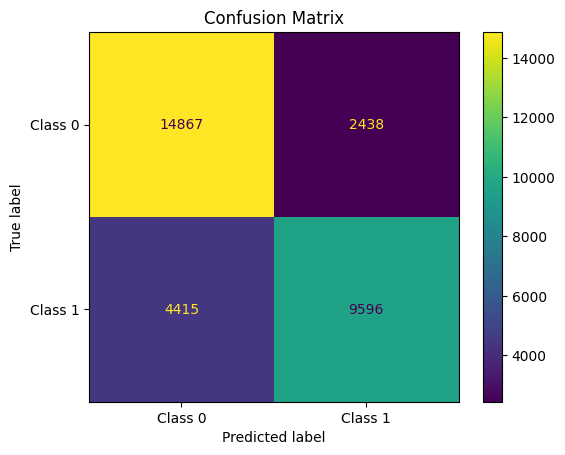

In [ ]:
print(predictions.shape)
print(y_test)
print(X_test_scaled)
print(y_test.squeeze().shape)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_test.squeeze(), predictions.squeeze())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()


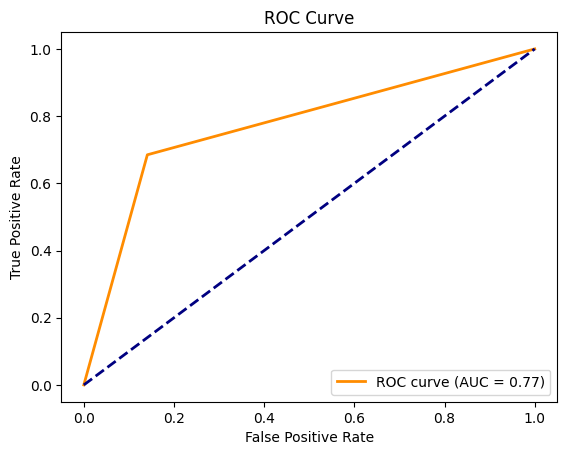

In [ ]:
from sklearn.metrics import roc_curve, auc
# which model is this ROC curve for?
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

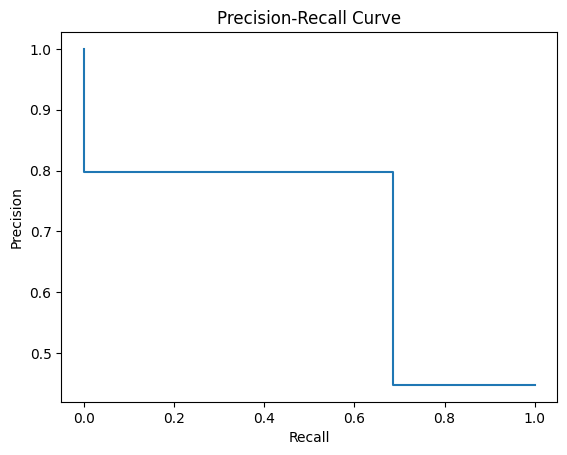

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# Plot precision-recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title('Precision-Recall Curve')
plt.show()

LR WITH OTHER METRICS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

log_reg = LogisticRegression(C=10, penalty='l2')
log_reg.fit(X_train_scaled, y_train.values.ravel())
predictions = log_reg.predict(X_test_scaled)
confusion_matrix_results = confusion_matrix(y_test.values.ravel(), predictions)
print("Confusion Matrix:")
print(confusion_matrix_results)

accuracyScore = accuracy_score(y_test.values.ravel(), predictions)
print(f"Accuracy Score: {accuracyScore}")

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test.values.ravel(), predictions)
print("Classification Report:")
print(classification_rep)


Confusion Matrix:
[[14869  2436]
 [ 4414  9597]]
Accuracy Score: 0.7812619747094137
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81     17305
           1       0.80      0.68      0.74     14011

    accuracy                           0.78     31316
   macro avg       0.78      0.77      0.77     31316
weighted avg       0.78      0.78      0.78     31316



**XGBoost**

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'scale_pos_weight': 'balanced',
}

dtrain = xgb.DMatrix(X_train_scaled, label=y_train_numeric)


xgb_model = xgb.train(params, dtrain)

dtest = xgb.DMatrix(X_test_scaled)
predictions = xgb_model.predict(dtest)

predictions_labels = label_encoder.inverse_transform(predictions.astype(int))

confusion_matrix_results = confusion_matrix(y_test, predictions_labels)
print("Confusion Matrix:")
print(confusion_matrix_results)

accuracyScore = accuracy_score(y_test, predictions_labels)
print(f"Accuracy Score: {accuracyScore}")

classification_rep = classification_report(y_test, predictions_labels)
print("Classification Report:")
print(classification_rep)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:54:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[17166   255]
 [ 3863  3073]]
Accuracy Score: 0.8309315597158927
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89     17421
           1       0.92      0.44      0.60      6936

    accuracy                           0.83     24357
   macro avg       0.87      0.71      0.75     24357
weighted avg       0.85      0.83      0.81     24357



In [ ]:
unique_labels = np.unique(y_train)
print(unique_labels)


[0 1]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

log_reg = LogisticRegression(class_weight='balanced')

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train.values.ravel())

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)
accuracyScore = accuracy_score(y_test.values.ravel(), predictions)
print(f"Accuracy Score: {accuracyScore}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy Score: 0.7319456419099232


# **SUMMARY**

Steps done:

To solve the class imbalance, we have used SMOTE. (Use the bar graph to show the class imbalance.)

To be done:

Which features do we actually need?

Next steps:


Commitments:

Pavithra: Going to add the random forest and decision trees code to the ensemble method. ElasticNetCV as well, please. Fix the grid search for logistic regression.

Mehdia: Graphical representations

Jonathan: Perform PCA on the scaled and normalized data.

Rishi: Validation. Evaluation metrics (theory, which one should be best fit?)

Kathy: Can you also work on the graphical representations?

Sarth: Try improving existing models help with visualizations